In [145]:
import warnings
warnings.filterwarnings('ignore')
# num
%pylab inline
import pandas as pd
# signal
from scipy.ndimage import filters
from scipy import signal as sp, stats, ndimage
# ml
from sklearn import *
# viz
from matplotlib import gridspec
import matplotlib.colors as clrs
# util
import os
import util
import importlib
importlib.reload(util)
util.figsize()

Populating the interactive namespace from numpy and matplotlib


In [146]:
splot = subplot

In [147]:
util.data_labels.items()

dict_items([(0, 'chickenpox_newyork'), (1, 'measles_baltimore'), (2, 'mumps_newyork')])

## Feature engineering

Be patient - we'll do some applied machine learning here

Why are we not always using the Fourier Transform for representing signals? Come on, think about it: with the FT we can represent any signal _precisely_!

> This is a classic: as opposed to precisely modelling the data, we nowadays collect examples and extract features for representing that data in a statistical formulation of the problem. A.k.a. ...?

#### Invariance

Let's think about factors in the process of signal measurement against which the representation should be invariant.

- Background noise in audio
    - Cocktail party
- Illumination conditions in an image
    - Shadow, shading, highlights
- ...

<center><img src=images/color_derivatives.png width=800></center>

In feature extraction for machine learning, we aim to find the optimal trade-off between *discriminative power* and *invariance*.

- what is the most discriminative representation of a signal?

- what is the most invariant representation of a signal?

- what is other common terminology to denote this phenomenon?

<center><img src=images/abstraction.png width=400></center>

> (what is other common terminology to denote this phenomenon? => bias/variance tradeoff!)

### Feature extraction using filter banks

We can represent a signal by it's impuls response to a set of filters, commonly refered to as a *filter bank*. The filters are designed such that a signal's space/time and frequency characteristics are adequately measured.

Filter banks are often used for feature extraction as they generally offer a good tradeoff between discriminative power and invariance. Why?

> A filter response represents the similarity between the signal and the filter, while no explicit assumptions are being made about the underlying data-generating process. This generally results in robust representations.

In [148]:
def plot_signals(signals, labels):
    util.figsize(16, 6)
    nl = []
    for label in util.data_labels.keys():
        signals2 = signals[labels==label]
        nl.append(signals2.shape[0])
        maxi = min(6, len(signals2))
        for i in range(maxi):
            splot(2,3,i+1)
            plot(signals2[i])
    splot(2,3,1);
    util.legend(['{} ({})'.format(s,n) for (s,n) in zip(util.data_labels.values(), nl)])
    util.figsize()

So let's have a look, and get some data first. We'll stick with 1 dimension for now.

681 samples


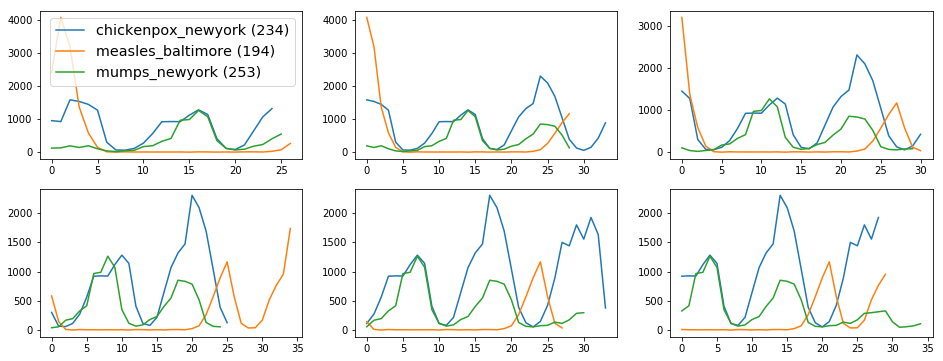

In [187]:
signals, labels = util.make_datamarket_health_dataset()
plot_signals(signals, labels)
print('{} samples'.format(len(signals)))

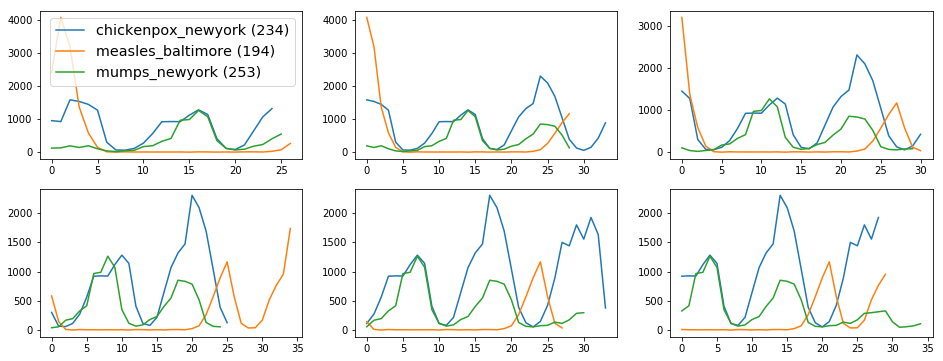

In [188]:
plot_signals(signals, labels)

What are interesting properties of this data? What kind of features would you like to extract for characterizing this data? How would you approach this?

> Interesting properties are: min, max, mean, periodicity, ... Choose appropriate filters and extract features by convolution.

#### Gabor filters

A popular filter for capturing space/time/frequency characteristics is the *Gabor filter*. These are mostly well-known in image processing but generally apply to signals of any dimension.

In [189]:
def plot_filter(f):
    plot(range(len(f)), f);
    xlim((0,len(f)))
    xticks([])

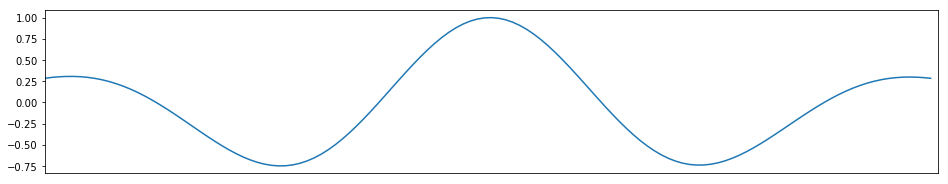

In [190]:
# create gabor filter: a gaussian with std s and a sinusoid with frequency f
def make_gabor_filter(s, f, sample_rate=None):
    sample_rate = s/10 if sample_rate is None else sample_rate
    t = arange(-s, +s, sample_rate)
    A = 1; p = 0;
    sinusoid = A * cos(f * t + p)
    gaussian = sp.gaussian(len(t), s**2)
    return sinusoid * gaussian

plot_filter(make_gabor_filter(pi/.5, 1, 0.1));

#### Gabor filters

The Gabor filter is one of many so called band pass filters that allows you to 'cut' the Fourier transform and isolate only specific information.

This is rather complex, but in the following we'll just assume that a Gabor filter is basically a sinusoid multiplied by a Gaussian, with which we can do cool stuff.

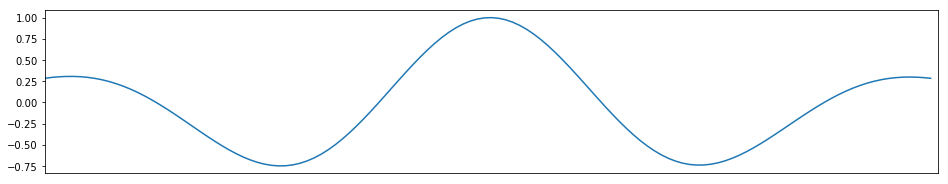

In [191]:
plot_filter(make_gabor_filter(pi/.5, 1, 0.1));

Now create a *filter bank* by considering a set of parameters for constructing Gabor filters

In [192]:
# create a filter bank from the given set of parameters
def make_gabor_filter_bank(params, sample_rate=0.25):
    return [make_gabor_filter(s, f, sample_rate) for (s,f) in params]

# make a sensible set of parameters for filter bank construction
# can you unravel this?
def get_gabor_filter_bank_params(
        # default parameter set
        std = arange(pi/2, pi/.5, pi/2),
        freq = arange(1, 4, 1)):
    # joint parameter set
    x, y = meshgrid(std, freq)
    return array([x.flatten(), y.flatten()]).T

In [193]:
# subplot arrangement for filter bank visualization
# by default fine grained sampling for visualization
def plot_gabor_filter_bank(params, sample_rate=0.1):
    util.figsize(14,6)
    # determine number of unique values of both parameters
    num_s = len(unique(params[:,0]))
    num_f = len(unique(params[:,1]))
    fb = make_gabor_filter_bank(params, sample_rate)
    for i in range(len(fb)):
        splot(num_s, num_f, i+1)
        plot_filter(fb[i])
        util.title('std={:.2f}, freq={:.2f}'.format(params[i,0], params[i,1]))
    util.figsize()

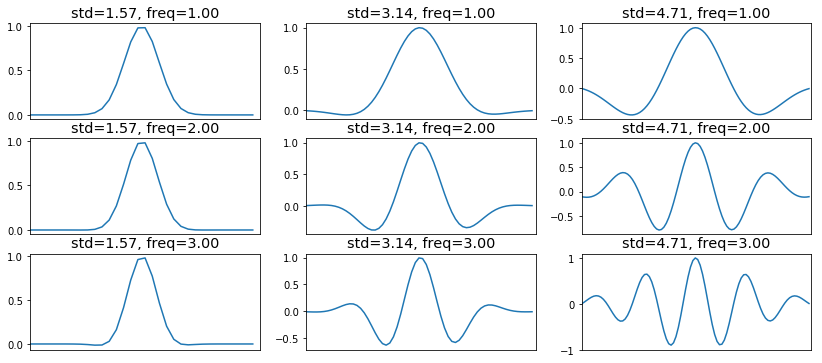

In [194]:
# show 'm
plot_gabor_filter_bank(get_gabor_filter_bank_params())

What do you observe?

### Signal classification using filter banks

Let's move on to a classification round using filter banks: which signal represents which disease?

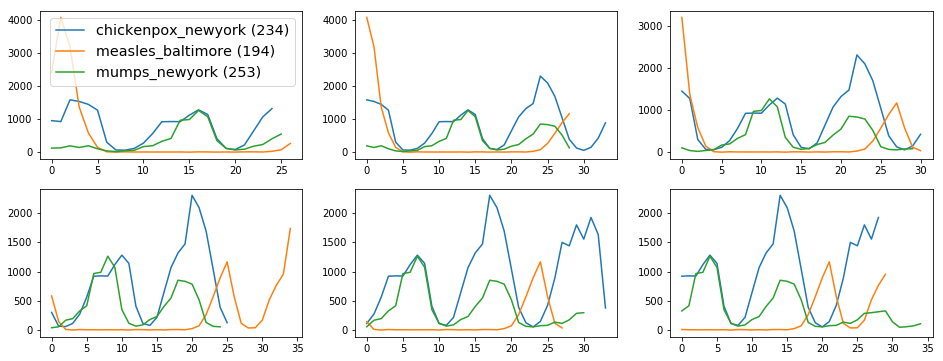

In [195]:
plot_signals(signals, labels);

For constructing fixed-length feature vectors, we need to convolve the signal and aggregate the filter response using some aggregator. This is know as _Feature Pooling_.

In [197]:
# default feature aggregation, a.k.a. pooling
default_feature_aggregators = [mean, std]

# apply a given set of functions the the given data
def apply_all(x, fs):
    return array([f(x) for f in fs])

# apply a filterbank to a signal
# and extract features using the provided aggregators
def apply_filter_bank(v, fb, aggregators=default_feature_aggregators):
    fb_result = [apply_all(convolve(v, f, 'valid'), aggregators) for f in fb]
    return array(fb_result).flatten()

In [198]:
# build the filter bank
gabor_params = get_gabor_filter_bank_params()
fb = make_gabor_filter_bank(gabor_params)

# apply the filter bank to a signal
apply_filter_bank(signals[0], fb)

array([ 1647.50062302,   685.19939252, -1583.30610908,   -76.07398258,
        -502.51538856, -7124.37420451, -1183.9161338 ,   366.42548549,
       -1811.61951101])

What do those numbers mean?

> For each of the 9 filters, we pool the result with a mean and var aggregator. This yields 18 numbers.

In [199]:
# apply the filterbank to all signals
def extract_gabor_features(signals, fb, aggregators=default_feature_aggregators):
    return array([apply_filter_bank(signal, fb, aggregators) 
                  for signal in signals])

gabor_features = extract_gabor_features(signals, fb)
gabor_features.shape # why this shape?

(681, 9)

In [200]:
# leave-one-out classification round with gabor features
result1 = util.l1o_model_validation(gabor_features, labels)
print('gabor features l1o: {:.0f}%'.format(100*result1))

gabor features l1o: 91%


Pretty good! Are you happy?

> At this point you should be unsatisfied: we have not compared against a simple baseline, plus we don't know what happens inside *util.l1o_model_validation()* so the result is rather meaningless.

In [201]:
# scattered overview of features
def plot_features(numeric_features, numeric_labels):
    util.figsize(10,10)
    nfeats = numeric_features.shape[1]
    n = 0
    for i in range(nfeats):
        for j in range(nfeats):
            n += 1
            splot(nfeats, nfeats, n)
            scatter(numeric_features[:,i], numeric_features[:,j], c=numeric_labels)
            util.no_ticks(); xlabel('f{:.0f}'.format(i+1)); ylabel('f{:.0f}'.format(j+1))
    util.figsize()

### Signal classification using simple features

Let's extract some simple features from the signals, for reference. This is more or less what you might have done before attending this lecture.

In [202]:
# extract features from the given signals using the provided operations
def extract_simple_features(signals, ops):
    return array([apply_all(signal, ops) for signal in signals])

# compute and show some simple features that we could extract from those signals
simple_features = extract_simple_features(signals, default_feature_aggregators)

In [203]:
# how good are the simple features?
result2 = util.l1o_model_validation(simple_features, labels)
print('simple features l1o: {:.0f}%'.format(100*result2))

simple features l1o: 94%


Better than Gabor features!!?? So why care?

**Assignment**: beat the simple features by tuning the gabor filter bank using the function below.

In [184]:
def go_gabor_features(signals, labels, sample_rate=0.25):
    fb = make_gabor_filter_bank(
            get_gabor_filter_bank_params(),
            sample_rate=sample_rate)
    gf = extract_gabor_features(signals, fb)
    return util.l1o_model_validation(gf, labels)

print('result 3: {:.0f}%'.format(100*go_gabor_features(signals, labels)))

result 3: 83%


In [185]:
print('result 3: {:.0f}%'
      .format(100*go_gabor_features(signals, labels, sample_rate=1)))

result 3: 97%


So, apparently, it is the case that we should have used a coarser sample rate.

> Take home message: you can achieve excellent data representations based on Gabor filter banks for solving your signal classification problem. However, you must be concise and you should know what you're doing... such that you can tune the filter bank to fit your data. And then, the filter that best resembles your data might not be the most discriminative one.

Any ideas on how to further improve the classification results?

> Using max-pooling for constructing feature vectors is usually more discriminative than average-pooling. You might want to try that in the examples above. 

Et voila, now you understand even more about convolutional neural networks (see e.g. [this post](https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks))

In [29]:
# store the 1D gabor features for later usage
fb = make_gabor_filter_bank(get_gabor_filter_bank_params(), sample_rate=1)
gf = extract_gabor_features(signals, fb)
save('data/feats1D.npy', hstack([gf, labels.reshape((len(labels), 1))]));

### 2D Gabor filter banks: extracting image texture

Just for illustration

In [31]:
# gabor kernels are readily available in scikit-image
# (you don't have to install this if you don't want to)
from skimage.filters import gabor_kernel

In [32]:
def get_gabor_kernels(return_params=False):
    kernels = []
    params = []
    for theta in range(4): # hey now we can rotate the filter as well!
        theta = theta / 4. * pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernels.append(gabor_kernel(frequency, theta=theta,
                                            sigma_x=sigma, sigma_y=sigma))
                params.append((round(theta,2), sigma, frequency))
    if return_params:
        return kernels, params
    return kernels

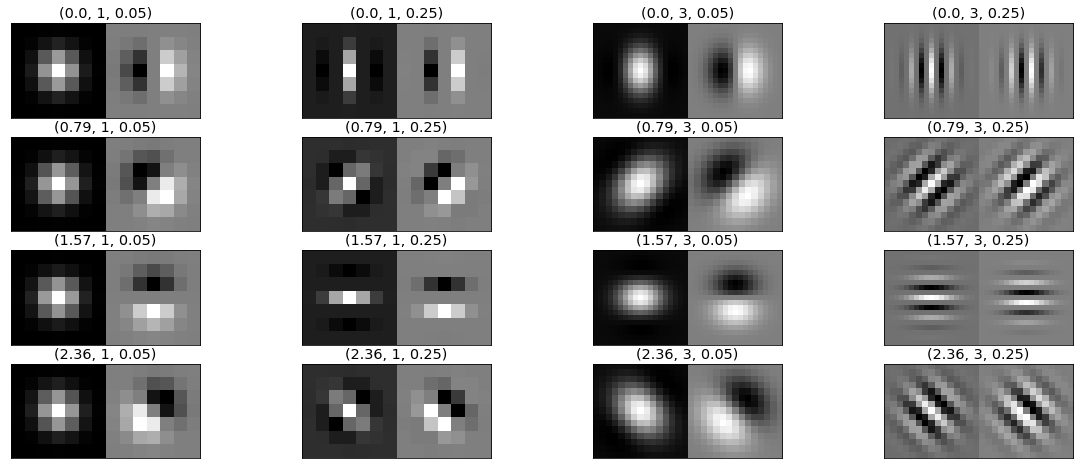

In [33]:
# prepare filter bank kernels
util.figsize(20, 8)
kernels, params = get_gabor_kernels(True)
for i in range(len(kernels)):
    splot(4, 4, i+1); # 16 kernels assumed
    util.imshow(hstack([util.imscale(real(kernels[i])), 
                        util.imscale(imag(kernels[i]))]))
    util.title(params[i])
util.figsize()

Showing real ('odd' / sine) and imaginary ('even' / cosine) parts of gabor filters at several orientations, scales and frequencies

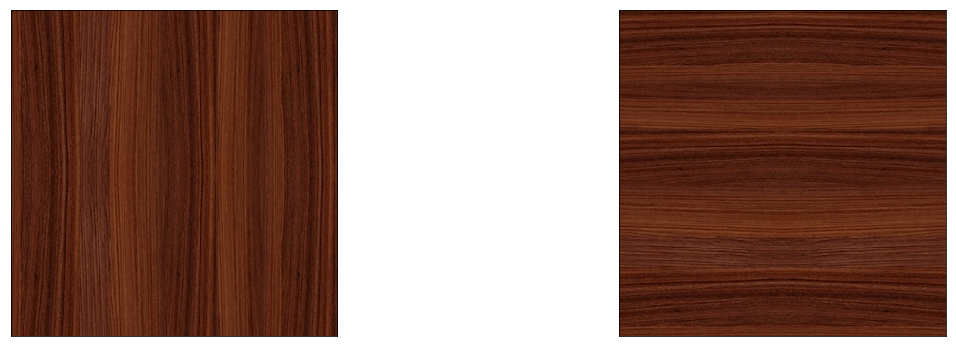

In [34]:
# let's extract gabor features from an image
wood1 = util.imread('images/vertical_wood.jpg');
wood2 = util.imread('images/horizontal_wood.jpg');
util.image_subplots([wood1, wood2])

In [35]:
def kernel_power(image, kernel):
    image = (image - image.mean()) / image.std()
    return sqrt(ndimage.convolve(image, real(kernel), mode='wrap')**2 +
                ndimage.convolve(image, imag(kernel), mode='wrap')**2)

def compute_kernel_feats(image, kernels):
    feats = zeros((len(kernels), 2), dtype=double)
    for k, kernel in enumerate(kernels):
        filtered = kernel_power(image, kernel)
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats
            
def plot_feat_hists(h1, h2):
    r = arange(len(h1))
    bar(r+0.00, h1[:,0], width=0.4);
    bar(r+0.40, h2[:,0], width=0.4);
    xticks(r)

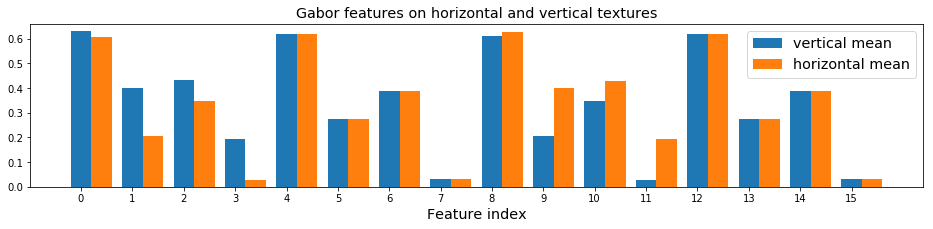

In [36]:
wood1_gabor_feats = compute_kernel_feats(mean(wood1, axis=2), kernels)
wood2_gabor_feats = compute_kernel_feats(mean(wood2, axis=2), kernels)
plot_feat_hists(wood1_gabor_feats, wood2_gabor_feats)
util.legend(['vertical mean','horizontal mean'])
util.xlabel('Feature index')
util.title('Gabor features on horizontal and vertical textures')

**Assignment**: explain the histogram by analyzing the filters and images

In [55]:
def compute_local_kernel_feats(image, kernels,
                               sample_rate=6, patch_size=24,
                               aggregators=[mean],
                               descriptors_only=True):
    
    # apply convolution with all provided kernels
    fstack = zeros((image.shape[0], image.shape[1], len(kernels)))
    for i, kernel in enumerate(kernels):
        fstack[:,:,i] = kernel_power(image, kernel)
    
    # naive implementation of grid-based feature sampling
    hsize = int(patch_size/2)
    rrange = range(hsize, image.shape[0]-hsize, sample_rate)
    crange = range(hsize, image.shape[1]-hsize, sample_rate)
    num_feats = len(rrange) * len(crange)
    feats = zeros((num_feats, fstack.shape[2] * len(aggregators)))
    locs = zeros((num_feats, 3))
    c = 0
    for i in rrange:
        for j in crange:
            f = fstack[i-hsize:i+hsize, j-hsize:j+hsize, :]
            for k, agg in enumerate(aggregators):
                kstart = k * fstack.shape[2]
                kend = (k+1) * fstack.shape[2]
                feats[c, kstart:kend] = agg(agg(f, axis=0), axis=0)
            locs[c, :] = [i, j, hsize]
            c += 1
    
    if descriptors_only:
        return feats
    return hstack([locs, feats])

In [56]:
# loc contains y,x,scale; use that to extract a patch from the given image
def get_patch(im, loc, zoom=20):
    # scale multiplier for patch extraction
    scale_mag = zoom * loc[2]
    # row range
    row_min = max(0, int(loc[0]-scale_mag))
    row_max = min(im.shape[0], int(loc[0]+scale_mag+1))
    col_min = max(0, int(loc[1]-scale_mag))
    col_max = min(im.shape[1], int(loc[1]+scale_mag+1))
    return im[arange(row_min, row_max),:][:,arange(col_min, col_max)]

#### Constructing a visual vocabulary with Gabor features

We'll go over it again later ;)

(16068, 16)

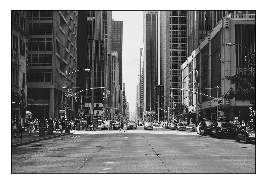

In [57]:
# read an image and extract LOCAL features
city = mean(util.imread('images/city.jpg'), axis=2)
local_gabor_features = compute_local_kernel_feats(city,
                                                  kernels,
                                                  descriptors_only=False)
locs = local_gabor_features[:, :3]
feats = preprocessing.StandardScaler(). \
            fit_transform(local_gabor_features[:, 3:])
util.imshow(city)
feats.shape

In [58]:
# perform clustering of the features to construct 10 visual words
gabor_vocab = cluster.KMeans(10).fit(feats)

In [59]:
# map the gabor features to their 'prototypes'
p = gabor_vocab.predict(feats)
image_descriptor = histogram(p, bins=10)[0]
# create the bow: the distribution of local features over visual words
image_descriptor / sum(image_descriptor)

array([ 0.05165546,  0.09366443,  0.04288026,  0.05047299,  0.21477471,
        0.1043067 ,  0.24184715,  0.11426438,  0.06248444,  0.02364949])

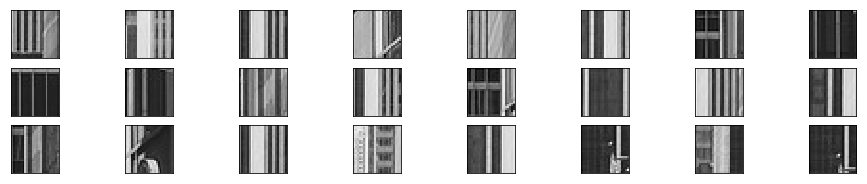

In [68]:
# determine which 'word' to show
word_nr = 0
l = random.permutation(locs[p==word_nr])
for i in range(len(l)):
    if i < 24:
        splot(3, 8, i+1)
        util.imshow(get_patch(city, l[i], zoom=1))

(3969, 16)


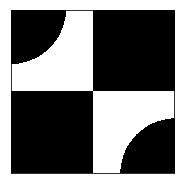

In [64]:
# do again, but with a simpler image
bim = mean(util.imread('images/bim.png'), 2)
util.imshow(bim)
bim_gabor_feats = compute_local_kernel_feats(bim, kernels, descriptors_only=False)
bim_locs = bim_gabor_feats[:, :3]
bim_feats = preprocessing.StandardScaler().fit_transform(bim_gabor_feats[:, 3:])
print(bim_feats.shape)

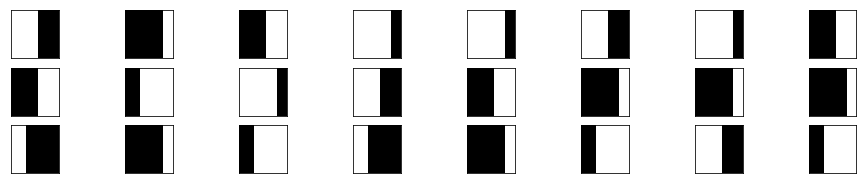

In [69]:
# and show a word
bim_p = gabor_vocab.predict(bim_feats)
bim_l = random.permutation(bim_locs[bim_p==word_nr])
for i in range(len(bim_l)):
    if i < 24:
        splot(3, 8, i+1)
        util.imshow(get_patch(bim, bim_l[i], zoom=1))

And maybe [this 3D Gabor application](https://www.youtube.com/watch?v=nNkL0fkTOjQ) is a nice way to conclude the Gabor stuff.

### Visual recognition with bags-of-visual-words

Before the rise of deep learning with convolutional neural networks, the status quo in computer vision was constituted by the bag-of-visual-words model. This model involves 1) adequately representing _local_ image features 2) constructing a visual vocabulary for vector quantizing the feature vectors and 3) training a classifier with the image features and associated labels (e.g. dog, cat). In the following we'll touch on the aspects involved.

#### BOVW 1) Representing image features

Probably the most cited article in computer vision is David Lowe's paper on [SIFT](https://computervisionblog.wordpress.com/2012/02/10/the-most-cited-papers-in-computer-vision/): the Scale Invariant Feature Transform. These are local image features that have dominated computer vision, and are typically better suitable for general vision problems than Gabor features.

There's quite a lot to it - here we'll focus on the Feature Transform part (it uses features based on the image gradient). But scroll through [the paper](http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) for the fun of it. 

Note the importance of _local_ features for robustness against geometric distortions due to scale, rotation, viewpoint and occlusion.

The most discriminative features for visual recognition in general are based on the image gradient. In the following, we'll focus on images from an urban and natural scene for illustration.

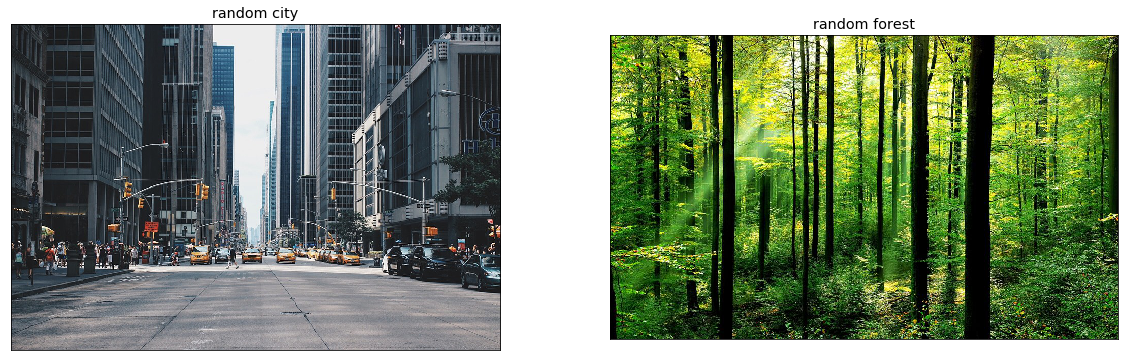

In [70]:
city = util.imread('images/city.jpg');
forest = util.imread('images/forest.jpg');
util.image_subplots([city, forest], ['random city', 'random forest'])

Compute image derivatives

In [71]:
def image_derivatives(im):
    return (util.image_derivative(im, 'x', False),
            util.image_derivative(im, 'y', False),
            util.image_derivative(im, 'grad', False))

city_dx, city_dy, city_grad = image_derivatives(city)
forest_dx, forest_dy, forest_grad = image_derivatives(forest)

Show 'm

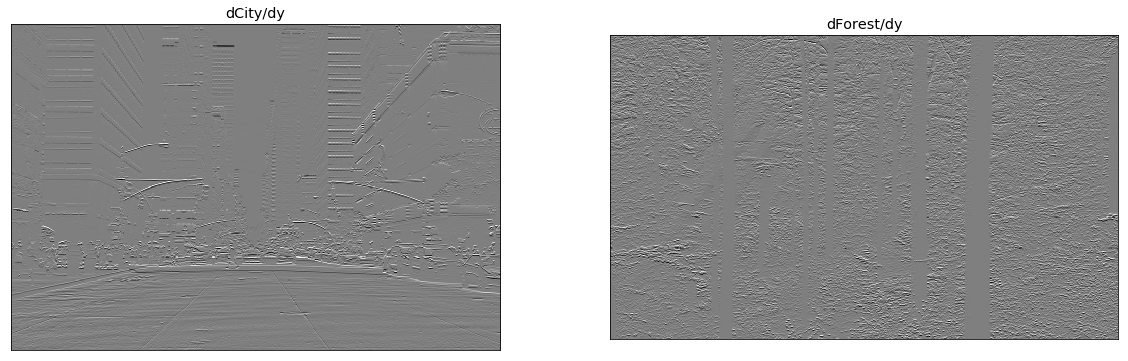

In [72]:
# show y derivative of city and forest
util.image_subplots([util.imscale(city_dy), util.imscale(forest_dy)],
                    ['dCity/dy', 'dForest/dy'])

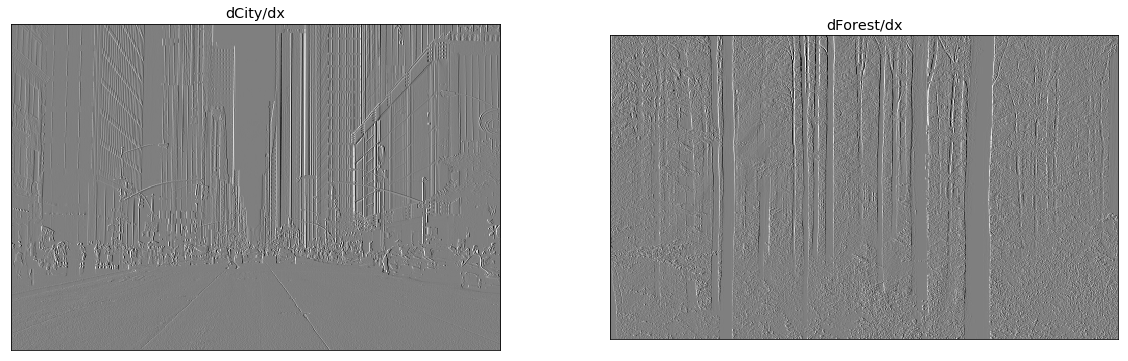

In [73]:
# show x derivative of city and forest
util.image_subplots([util.imscale(city_dx), util.imscale(forest_dx)],
                    ['dCity/dx', 'dForest/dx'])

What features would you extract to discriminate between these two scenes?

**Answer**: features based on the direction and magnitude of the image gradient

#### Histograms of oriented gradients

In [74]:
# compute an image's gradient orientations
def gradient_orientation(dx, dy, do_standardize = True):
    ori = arctan2(dy, dx)
    # orientations range from -pi to +pi, fix that
    if do_standardize:
        ori = (ori + pi) / (2 * pi)
    return ori

Hey, if we're gonna have radians in our image we can use the HSV color space for visualization (or HSI, or HSL). Most languages / viztools come with tools for converting between color spaces.

<table width='100%'>
    <tr>
        <td><center>RGB<br><img src='images/colorcube-1.png' width='200'></td>
        <td><center>HSV<br><img src='images/750px-HSV_cylinder.png' width='200'></td>
    </tr>
</table>

In [75]:
# assuming the values in the image are orientations
# make a visualisation in hsv color space
def orishow(ori_im, saturation=None, intensity=None):
    im = util.nxmx3(ori_im)
    im[:,:,1] = 1 if saturation is None else saturation
    im[:,:,2] = 1 if intensity is None else intensity
    return clrs.hsv_to_rgb(im)

city_ori = gradient_orientation(city_dx, city_dy)
forest_ori = gradient_orientation(forest_dx, forest_dy)

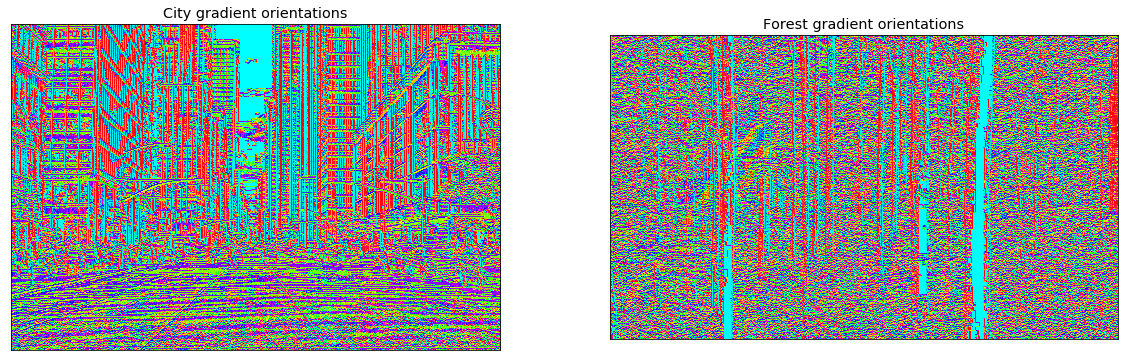

In [77]:
util.image_subplots(
    [orishow(city_ori), orishow(forest_ori)],
    ['City gradient orientations', 'Forest gradient orientations'])

Can you understand what is happening?

It is important to consider the gradient magnitude for the extraction of gradient features. Can you understand what happens if we assign the image gradient magnitude to the saturation channel, see the images below? What would happen if we assign the gradient magnitude to the intensity channel instead of the saturation?

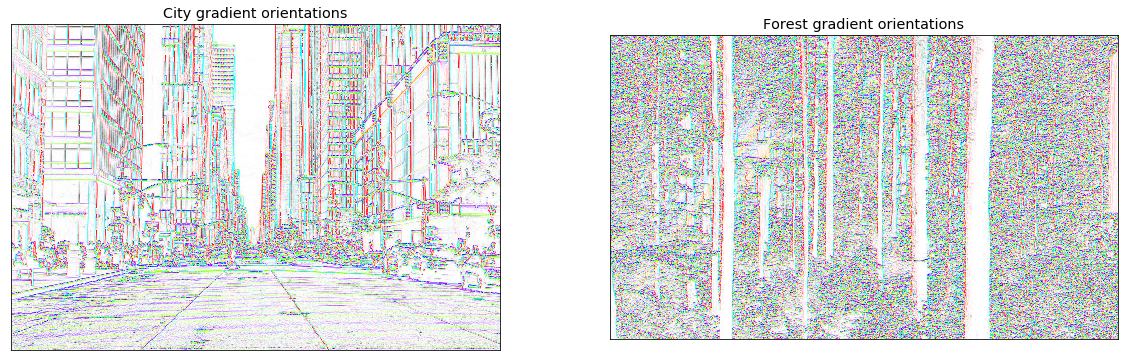

In [78]:
util.image_subplots(
    [orishow(city_ori, saturation=city_grad),
     orishow(forest_ori, saturation=forest_grad)],
    ['City gradient orientations', 'Forest gradient orientations'])

Looking at the distributions of derivatives and gradients, I would be pretty confident that we could bake some useful features for scene recognition! What about you?

In [93]:
def joint_hist(x1, x2):
    (v1,a1) = histogram(x1, 30)
    (v2,a2) = histogram(x2, 30)
    plot(.5*a1[1:]+.5*a1[:-1], v1);
    plot(.5*a2[1:]+.5*a2[:-1], v2);

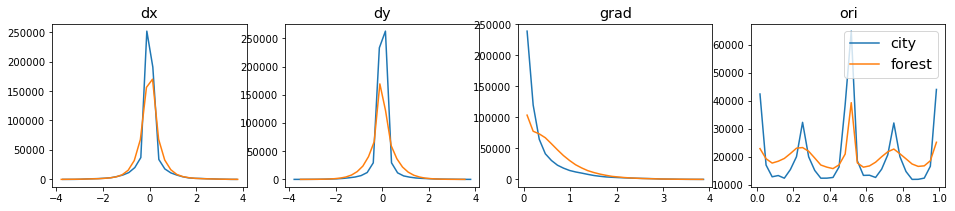

In [94]:
ftypes = ['dx', 'dy', 'grad', 'ori']
for i in range(len(ftypes)):
    splot(1,4,i+1);
    joint_hist(eval('city_'+ftypes[i]), eval('forest_'+ftypes[i]))
    util.title(ftypes[i])
util.legend(['city','forest'])

And of course I want an explanation of the oscillations in the last histogram ;)

#### BOVW 2) Making image representations

In the previous section, we focused on the transformation of image pixels to histograms of image gradient features.

These histograms are constructed from all image data, i.e. they are _global_ image representations. Therefore, these representations are not invariant against changes in viewpoint and illumination.

Therefore, the image representation should be based on _local_ image features, which are sampled from many locations in the image using some point sampling strategy.

In the next image, I want to emphasize that:

- image features are samples from many locations in the image, and processed such that the resulting feature vector is invariant against changes in viewpoint and illumination

- the most famous local image feature vector is called SIFT - in the image we see some colored variation thereof

- using a clustering of feature space, a visual vocabulary is constructed based on which a fixed-length image representation is achieved.

But the main message is: 

> #### You can use the bag-of-words model for representing any kind of data. You just have to define what a 'word' is for your data.

<img src="images/bovw.png">

image from Koen van de Sande

In the following, we'll build a BOW representation for a set of images from dogs and cats using scikit-learn and mahotas.

DO YOU HAVE ANY QUESTIONS?

SIFT is patented, so a lot of variations have been published, e.g. BRIEF, DAISY, ORB, SURF in packages such as scikit-image, Pillow, OpenCV and Mahotas. I found Mahotas to offer an excellent tradeoff between power and simplicity for this training context. For experienced users I would recommend OpenCV.

We will use the Speeded Up Robust Features, which is an efficient variation of SIFT, for both feature _detection_ and _description_. If you want, I can tell a lot more about it: it used [_integral images_](https://en.wikipedia.org/wiki/Summed_area_table), a data structure for super efficient feature extraction, also used in the [first commercial face detector](https://en.wikipedia.org/wiki/Viola–Jones_object_detection_framework).

Also, at the last European Conference on Computer Vision (ECCV 2016, Amsterdam) [the paper on SURF](http://www.vision.ee.ethz.ch/~surf/eccv06.pdf) was awarded 'best paper of ECCV 10 years ago'.

In [86]:
# import surf from Mahotas
from mahotas.features import surf

ucity = util.float3d_to_uint2d(city)
uforest = util.float3d_to_uint2d(forest)

# detect feature locations and extract feature vectors by a single call
# let's not worry about all the possible parameter settings and focus on BOVW instead
city_features = surf.surf(ucity)
forest_features = surf.surf(uforest)

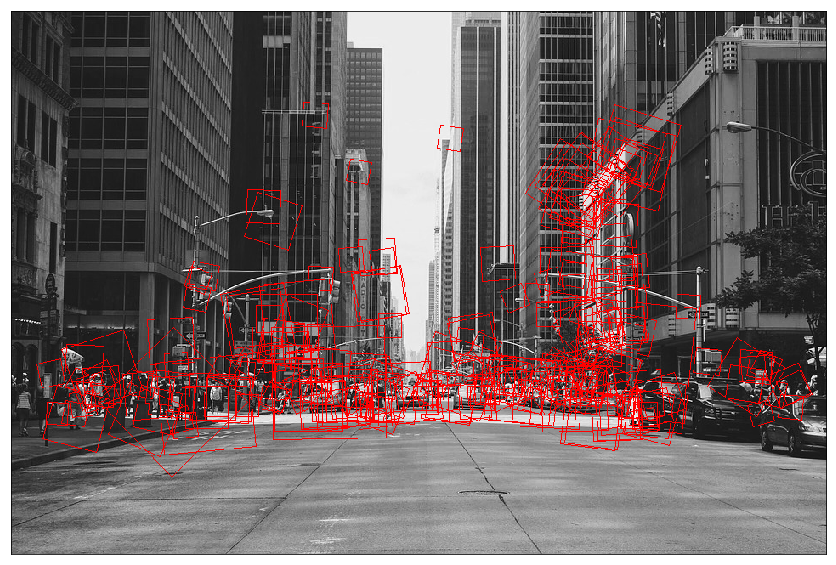

In [65]:
# Plotting the local features on the image canvas, we can see the different scales and orientations.
util.figsize(20,10);
util.imshow(surf.show_surf(ucity, city_features[:250]))

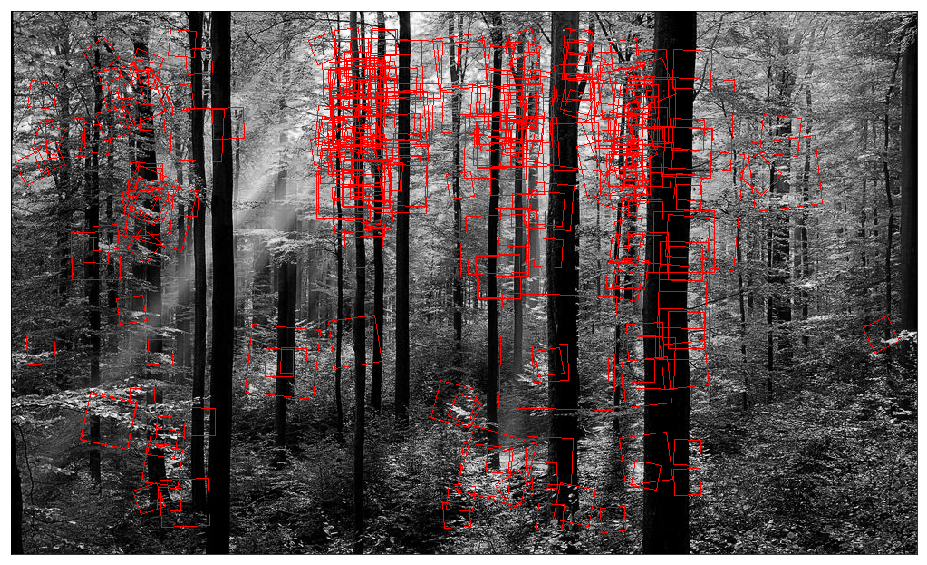

In [66]:
util.imshow(surf.show_surf(uforest, forest_features[:250]));
util.figsize()

Let's solve a problem: discriminate between dogs and cats

In [82]:
# obtain filepaths and labels
label_dict = {'cat': 0, 'dog': 1}
data_dir = 'data/cat_dog/';
filenames = os.listdir(data_dir)
filepaths = []; labels = []
for filename in filenames:
    if filename.endswith('jpg'):
        filepaths.append(data_dir+filename)
        labels.append(label_dict[filename[:3]])
labels = array(labels)
print(len(labels), 'files,', sum(labels), 'dogs,',
      len(labels)-sum(labels), 'cats')

100 files, 50 dogs, 50 cats


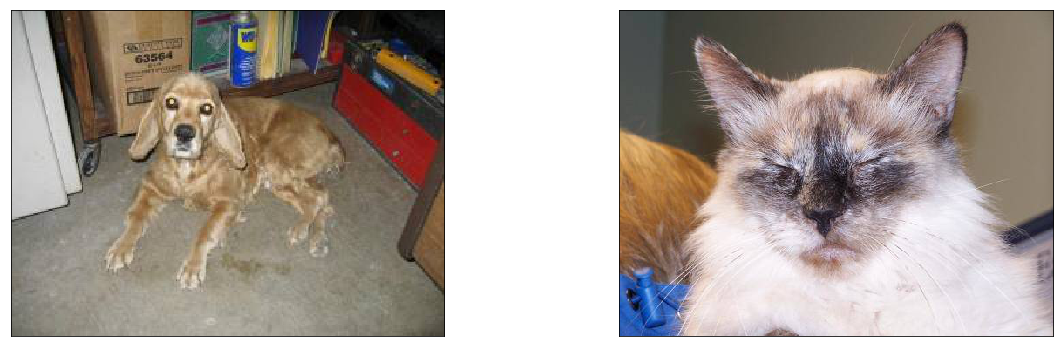

In [83]:
util.image_subplots([util.imread(filepaths[1], edit_dir=False),
                     util.imread(filepaths[-2], edit_dir=False)])

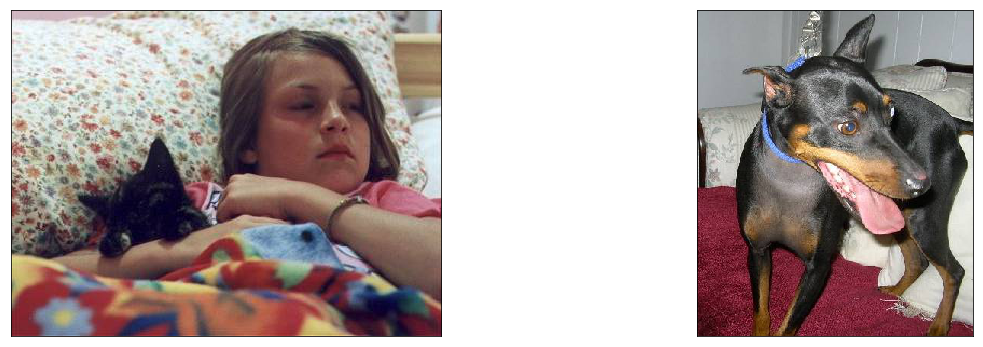

In [84]:
util.image_subplots([util.imread(filepaths[0], edit_dir=False),
                     util.imread(filepaths[-1], edit_dir=False)])

That looks like a pretty hard problem

We'll be extracting dense features, because that usually performs better than sampling from keypoints (more=more). And, in addition to that, in this lecture we're using only 100 images but we need enough data to be able to construct the bags-of-visual-words.

In [87]:
# we don't want to be storing images and features, 
# so use a filepath for feature extraction
def extract_surf_features(filepath, num_feats=None, descriptors_only=True):
    im = util.float3d_to_uint2d(util.imread(filepath, edit_dir=False))
    feats = surf.dense(im, 4, scale=1,
                       include_interest_point=not descriptors_only);
    if num_feats is not None and num_feats < feats.shape[0]:
        return feats[random.permutation(range(feats.shape[0]))[:num_feats]]
    return feats

# different numbers of descriptors, with/out location/scale/orientation
for fp, b in zip([filepaths[0], filepaths[-1]], [True, False]):
    print(extract_surf_features(fp, descriptors_only=b).shape, fp)

(6256, 64) data/cat_dog/cat.6.jpg
(8217, 70) data/cat_dog/dog.13.jpg


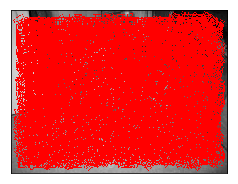

In [88]:
# this is what densely sampled local features look like
util.imshow(
    surf.show_surf(util.float3d_to_uint2d(util.imread(filepaths[1],
                                                      edit_dir=False)),
    extract_surf_features(filepaths[1], descriptors_only=False)))

Now we can harvest features for creating a visual vocabulary

In [91]:
# choose some number of visual words
# more => discriminative power, less => invariance
num_words = 100

In [90]:
# function for creating the visual vocabulary
def create_visual_vocabulary(filepaths, k, num_features_for_clustering=10000):
    num_features_per_file = int(num_features_for_clustering / len(filepaths))
    all_feats = None
    for filepath in filepaths:
        feats = extract_surf_features(filepath, num_feats=num_features_per_file)
        if all_feats is None:
            all_feats = feats.copy()
        else:
            all_feats = append(all_feats, feats, axis=0)
    km = cluster.KMeans(k, n_jobs=-1)
    km.fit(all_feats)
    return km

In [137]:
# construct the vocabulary (may take a while)
surf_vocab = create_visual_vocabulary(filepaths, num_words)
surf_vocab

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [93]:
# visualize the features in an image from a cluster
# if w is none, use the most frequent
def show_surf_word(filepath, vocab, w=None):
    f = extract_surf_features(filepath, descriptors_only=False)
    p = vocab.predict(f[:,6:])
    if w is None: # choose most frequent
        w = argmax(histogram(p, range(vocab.n_clusters))[0])
    locs = f[p==w, 0:3]
    locs = random.permutation(locs)
    im = util.float3d_to_uint2d(util.imread(filepath, edit_dir=False))
    num_rows, num_cols = 3, 8
    for i in range(len(locs)):
        if i < len(locs) and i < num_rows*num_cols:
            splot(num_rows, num_cols, i+1)
            util.imshow(get_patch(im, locs[i]))

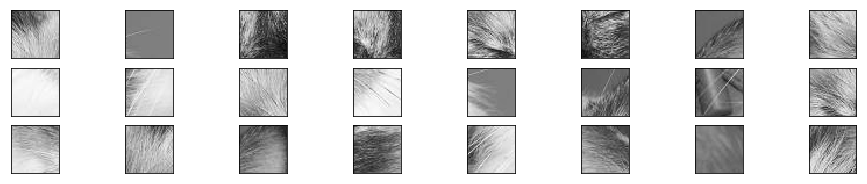

In [94]:
# we can look at the patches in an image
# that are assigned to the same visual word
show_surf_word(filepaths[-2], surf_vocab)

**Assignment**: Find a nice cluster and compare across images. This might be a bit of a pain due to the fact that the descriptors are rotationally invariant and are also sampled from low-gradient locations...

In [95]:
# now use all this to create a single image descriptor that can be used in a machine learning setup
def extract_image_descriptor(filepath, vocab):
    visual_word_assignments = vocab.predict(extract_surf_features(filepath))
    visual_word_distribution = histogram(visual_word_assignments,
                                         range(vocab.n_clusters+1))[0].reshape(1,-1)
    return preprocessing.normalize(array(visual_word_distribution, dtype='float'),
                                   norm='l2')[0]

#### BOVW 3) Construct image descriptors and use your favorite classifier for visual recognition

In [138]:
# extract image descriptors more efficiently with multiprocessing
import multiprocessing as mp

def extract_surf_descriptor(filepath):
    global surf_vocab
    return extract_image_descriptor(filepath, surf_vocab)

with mp.Pool(6) as descriptor_pool:
    image_descriptors = array(descriptor_pool.map(extract_surf_descriptor,
                                                  filepaths))

In [139]:
# evaluate performance of cat/dog recognition
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
for cls in [neighbors.KNeighborsClassifier(1),\
            LogisticRegression(),\
            SVC(kernel='linear')]:
    res = util.l1o_model_validation(image_descriptors,
                                    array(labels),
                                    classifier=cls)
    print('{}: {:.0f}%'.format(cls.__str__().split('(')[0], 100*res))

KNeighborsClassifier: 63%
LogisticRegression: 64%
SVC: 59%


There are many more things to optimize...

In [143]:
# wrapper around the important stuff for doing a grid search
# of course, this could be extended with the classifier params
def bovw_gridsearch(filepaths, labels,
                    ks=[10, 50, 100, 500],
                    ns=[10000, 50000]):
    global surf_vocab
    res = []
    for k in ks:
        for n in ns:
            surf_vocab = create_visual_vocabulary(filepaths, k, n)
            with mp.Pool(6) as descriptor_pool:
                image_descriptors = array(descriptor_pool.map(
                                            extract_surf_descriptor,
                                            filepaths))
            p = util.l1o_model_validation(image_descriptors,
                                          array(labels),
                                          classifier=LogisticRegression())
            print('k:',k,'n:',n,'p:',p)
            res.append([k,n,p])
    return array(res)

In [144]:
bovw_gs = bovw_gridsearch(filepaths, labels)

k: 10 n: 10000 p: 0.57
k: 10 n: 50000 p: 0.59
k: 50 n: 10000 p: 0.57
k: 50 n: 50000 p: 0.56
k: 100 n: 10000 p: 0.58
k: 100 n: 50000 p: 0.63
k: 500 n: 10000 p: 0.64
k: 500 n: 50000 p: 0.58


In case of spare time and enthousiasm: redo this round of classification with local gabor features instead of surf.

In [83]:
# store the bovw features for later usage
save('data/feats2D.npy', hstack([image_descriptors, labels.reshape((len(labels),1))]))